In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.datasets import fashion_mnist

In [8]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
x_test.shape

(10000, 28, 28)

In [11]:
x_train[0].dtype

dtype('uint8')

In [12]:
x_train=x_train.reshape(60000,28,28,1)
x_test=x_test.reshape(10000,28,28,1)

x_train,x_test=x_train/255,x_test/255

x_train=x_train.astype('float')
x_test=x_test.astype('float')

In [14]:
y_train[0]

9

In [15]:
model=tf.keras.Sequential([
                           tf.keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape=(28,28,1)),
                           tf.keras.layers.MaxPooling2D(),
                           tf.keras.layers.Conv2D(32,3,activation='relu',padding='same'),
                           tf.keras.layers.MaxPooling2D(),
                           tf.keras.layers.Conv2D(64,3,activation='relu',padding='same'),
                           tf.keras.layers.MaxPooling2D(),
                           tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
                           tf.keras.layers.GlobalAveragePooling2D(),
                           tf.keras.layers.Dense(10,activation='softmax')

])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [18]:
history=model.fit(x_train,y_train,batch_size=32,validation_split=0.1,epochs=5,verbose=1)

Epoch 1/5
1688/1688 [==============================] - 51s 30ms/step - loss: 0.6214 - accuracy: 0.7707 - val_loss: 0.4556 - val_accuracy: 0.8313
Epoch 2/5
1688/1688 [==============================] - 50s 30ms/step - loss: 0.3754 - accuracy: 0.8635 - val_loss: 0.3258 - val_accuracy: 0.8815
Epoch 3/5
1688/1688 [==============================] - 49s 29ms/step - loss: 0.3153 - accuracy: 0.8856 - val_loss: 0.2979 - val_accuracy: 0.8915
Epoch 4/5
1688/1688 [==============================] - 48s 29ms/step - loss: 0.2785 - accuracy: 0.8989 - val_loss: 0.2686 - val_accuracy: 0.9025
Epoch 5/5
1688/1688 [==============================] - 48s 29ms/step - loss: 0.2530 - accuracy: 0.9073 - val_loss: 0.2589 - val_accuracy: 0.9088


In [20]:
model.layers[-1].name

'dense'

In [22]:
model.layers[-2].name

'global_average_pooling2d'

In [23]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [25]:
cam_model=tf.keras.Model(inputs=model.input,outputs=[model.layers[-3].output,model.layers[-1].output
                                                     ])

In [26]:
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

In [27]:
features,results=cam_model.predict(x_test)

In [30]:
features.shape

(10000, 3, 3, 128)

In [29]:
results[0]

array([1.2886995e-05, 5.2947208e-08, 7.3077990e-07, 2.5736360e-06,
       1.2322137e-06, 4.1586501e-04, 1.7374230e-06, 7.4526407e-02,
       1.9748783e-05, 9.2501879e-01], dtype=float32)

In [31]:
last_dense_layer=model.layers[-1]


In [32]:
gap_layer=last_dense_layer.get_weights()

In [40]:
gap_layer[0].shape

(128, 10)

In [41]:
gap_weights=gap_layer[0]

In [45]:
import scipy as sp

In [49]:
def show_cam(image_index):
  features_for_img=features[image_index,:,:,:]
  prediction=np.argmax(results[image_index])
  class_activation_weights=gap_weights[:,prediction]
  class_activation_features=sp.ndimage.zoom(features_for_img,(28/3,28/3,1),order=2)
  cam_output=np.dot(class_activation_features,class_activation_weights)
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  
  # show the upsampled image
  plt.imshow(np.squeeze(x_test[image_index],-1), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [50]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images 
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

please choose a class less than 10
Predicted Class = 0, Probability = 0.9377665


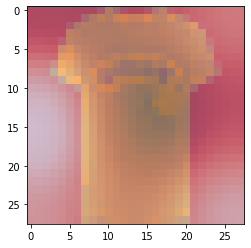

Predicted Class = 0, Probability = 0.5168508


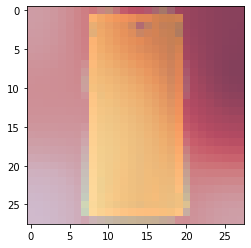

Predicted Class = 0, Probability = 0.9386976


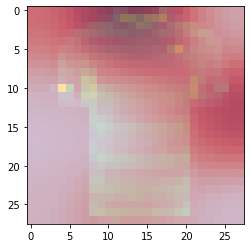

Predicted Class = 0, Probability = 0.7707299


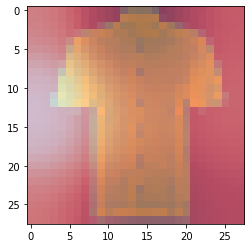

Predicted Class = 0, Probability = 0.9953134


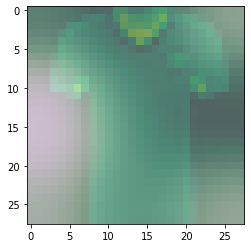

In [51]:
show_maps(0,5)